In [1]:
import pandas as pd

In [2]:
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [6]:
def feature_engineering(df):
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]
    
    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]

    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    df['Age'] = df['Age'].apply(lambda x: 3 if x<3 else x)
    df['Age'] = df['Age'].apply(lambda x: 100 if x>100 else x)

    #df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan
    
    # 평균값으로 대체
    #df['Age'] = df['Age'].fillna(df['Age'].mean())
    #df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    
    # 평점이 0인 유저와 0이 아닌 유저 분류
    zero_user = train[train['Book-Rating'] == 0][['User-ID', 'Book-Rating']].drop_duplicates()['User-ID']
    df['Rating_gb'] = np.where(df['User-ID'].isin(zero_user), 0, 1)
    
    return df
def columns_create():    
    global train_lb, test_lb
    # User-ID기준 Rating count & check
    count_columns = []
    check_columns = []
    for i in range(11):
        train_lb[f"count_{i}"] = train_lb[train_lb['Book-Rating'] == i].groupby(['User-ID'])['Book-Rating'].transform('count')
        train_lb[f"count_{i}"] = train_lb[f"count_{i}"].fillna(0)
    
        train_lb[f"check_{i}"] = np.where(train_lb[f"count_{i}"] > 0, 1, 0)        
        count_columns.append(f"count_{i}")
        check_columns.append(f"check_{i}")   
    create_columns = count_columns + check_columns
    for i in range(11):
        train_lb[f"count_{i}"] = train_lb.groupby(['User-ID'])[f"count_{i}"].transform('max')
        train_lb[f"check_{i}"] = train_lb.groupby(['User-ID'])[f"check_{i}"].transform('max')   
    ct_ck_set = train_lb[['User-ID'] + create_columns].drop_duplicates()
    test_lb = pd.merge(test_lb, ct_ck_set, on = 'User-ID', how = 'left')
    test_lb[create_columns] = test_lb[create_columns].fillna(0)    


In [7]:
import re 
def preprocessing_data(df):
    
    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    
    # 최빈값을 사용하기 위해 새로운 데이터 프레임 생성(pd.Series.mode를 이용하면 같은 count수의 값을 list로 묶어서 정확하지 않음)
    new_state = train_lb.groupby(['City'])['State'].value_counts().to_frame().rename(columns = {'State' : 'count'}).reset_index()
    new_state = new_state[(~new_state['City'].isna())&(~new_state['State'].isna())&(new_state['count']!=1)]
    new_state = new_state.sort_values(by=['City', 'count'], ascending=[True, False]).drop_duplicates(subset='City', keep='first')
    new_state = new_state.rename(columns = {'State' : 'N_State'}) 
    new_state = new_state.drop(columns = ['count'])
    
    new_country = train_lb.groupby(['State'])['Country'].value_counts().to_frame().rename(columns = {'Country' : 'count'}).reset_index()
    new_country = new_country[(~new_country['State'].isna())&(~new_country['Country'].isna())&(new_country['count']!=1)]
    new_country = new_country.sort_values(by=['State', 'count'], ascending=[True, False]).drop_duplicates(subset='State', keep='first')
    new_country = new_country.rename(columns = {'Country' : 'N_Country'}) 
    new_country = new_country.drop(columns = ['count'])
    
    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')
    
    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])
    
    # 채워지지 않은 값은 Unknown 처리
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State'])
    
    return df
    

In [8]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()


train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))


In [9]:
X_train = train_lb.drop(columns = ['ID' , 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID'])

<Figure size 700x700 with 0 Axes>

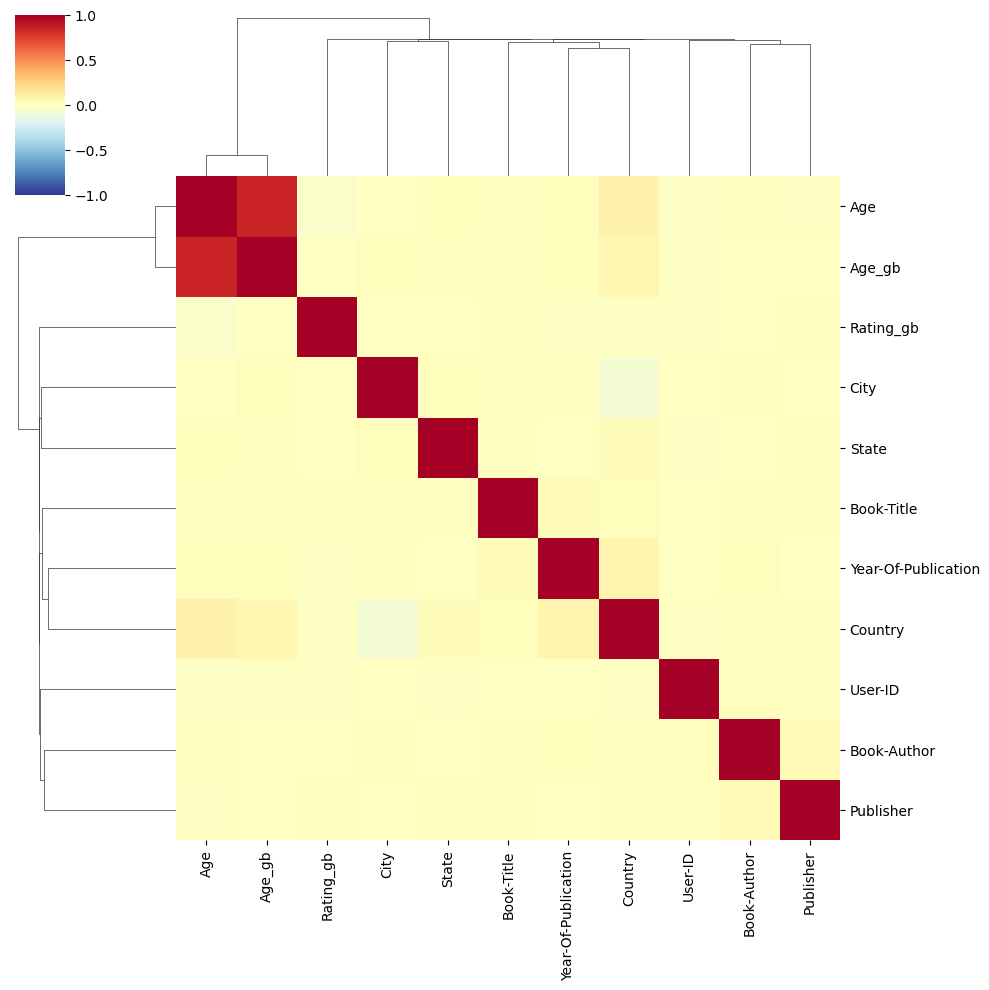

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (7, 7))
clustermap = sns.clustermap(X_train.corr(), cmap = 'RdYlBu_r',vmin = -1, vmax = 1, annot = False)

In [11]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

0it [00:00, ?it/s]


Fold  0
0:	learn: 3.8379682	test: 3.8377440	best: 3.8377440 (0)	total: 108ms	remaining: 15m 40s
500:	learn: 3.1733771	test: 3.1466907	best: 3.1466907 (500)	total: 47.7s	remaining: 12m 59s
1000:	learn: 3.1306631	test: 3.1235120	best: 3.1235120 (1000)	total: 1m 35s	remaining: 12m 16s
1500:	learn: 3.1014997	test: 3.1136269	best: 3.1136166 (1499)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.0761110	test: 3.1080323	best: 3.1080323 (2000)	total: 3m 13s	remaining: 10m 45s
2500:	learn: 3.0527429	test: 3.1044461	best: 3.1044461 (2500)	total: 4m 2s	remaining: 10m
3000:	learn: 3.0308771	test: 3.1019257	best: 3.1019257 (3000)	total: 4m 51s	remaining: 9m 13s
3500:	learn: 3.0104432	test: 3.1001382	best: 3.1001382 (3500)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9913818	test: 3.0989326	best: 3.0989326 (4000)	total: 6m 30s	remaining: 7m 38s
4500:	learn: 2.9718455	test: 3.0976987	best: 3.0976987 (4500)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9530102	test: 3.0968799	best: 3.0968799 (4996

1it [10:11, 611.25s/it]


Fold  1
0:	learn: 3.8379450	test: 3.8378655	best: 3.8378655 (0)	total: 91.4ms	remaining: 13m 14s
500:	learn: 3.1736931	test: 3.1438776	best: 3.1438776 (500)	total: 47.7s	remaining: 13m
1000:	learn: 3.1307286	test: 3.1193933	best: 3.1193933 (1000)	total: 1m 35s	remaining: 12m 14s
1500:	learn: 3.1015972	test: 3.1086708	best: 3.1086708 (1500)	total: 2m 23s	remaining: 11m 28s
2000:	learn: 3.0768341	test: 3.1026620	best: 3.1026620 (2000)	total: 3m 12s	remaining: 10m 44s
2500:	learn: 3.0545233	test: 3.0992146	best: 3.0992146 (2500)	total: 4m 1s	remaining: 9m 58s
3000:	learn: 3.0327586	test: 3.0965890	best: 3.0965873 (2999)	total: 4m 51s	remaining: 9m 12s
3500:	learn: 3.0116979	test: 3.0947101	best: 3.0947101 (3500)	total: 5m 40s	remaining: 8m 25s
4000:	learn: 2.9916869	test: 3.0935015	best: 3.0935015 (4000)	total: 6m 30s	remaining: 7m 38s
4500:	learn: 2.9728004	test: 3.0925634	best: 3.0925504 (4486)	total: 7m 21s	remaining: 6m 51s
5000:	learn: 2.9537487	test: 3.0914366	best: 3.0914260 (4991

2it [22:10, 674.58s/it]


Fold  2
0:	learn: 3.8379484	test: 3.8377416	best: 3.8377416 (0)	total: 95.8ms	remaining: 13m 52s
500:	learn: 3.1753190	test: 3.1342997	best: 3.1342997 (500)	total: 47.8s	remaining: 13m 1s
1000:	learn: 3.1328529	test: 3.1089502	best: 3.1089502 (1000)	total: 1m 36s	remaining: 12m 20s
1500:	learn: 3.1015283	test: 3.0981467	best: 3.0981467 (1500)	total: 2m 25s	remaining: 11m 35s
2000:	learn: 3.0758061	test: 3.0928343	best: 3.0928343 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.0527798	test: 3.0894404	best: 3.0894404 (2500)	total: 4m 6s	remaining: 10m 9s
3000:	learn: 3.0310444	test: 3.0870781	best: 3.0870781 (3000)	total: 4m 56s	remaining: 9m 21s
3500:	learn: 3.0105058	test: 3.0854610	best: 3.0854610 (3500)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 2.9905057	test: 3.0843122	best: 3.0843122 (4000)	total: 6m 34s	remaining: 7m 43s
4500:	learn: 2.9705642	test: 3.0832881	best: 3.0832881 (4500)	total: 7m 24s	remaining: 6m 54s
5000:	learn: 2.9514201	test: 3.0824824	best: 3.0824824 (5

3it [33:16, 671.02s/it]


Fold  3
0:	learn: 3.8380038	test: 3.8377515	best: 3.8377515 (0)	total: 91ms	remaining: 13m 10s
500:	learn: 3.1736071	test: 3.1330784	best: 3.1330784 (500)	total: 47.9s	remaining: 13m 3s
1000:	learn: 3.1318947	test: 3.1110938	best: 3.1110938 (1000)	total: 1m 35s	remaining: 12m 16s
1500:	learn: 3.1020894	test: 3.1019063	best: 3.1019063 (1500)	total: 2m 24s	remaining: 11m 31s
2000:	learn: 3.0761301	test: 3.0970389	best: 3.0970389 (2000)	total: 3m 13s	remaining: 10m 46s
2500:	learn: 3.0522902	test: 3.0940503	best: 3.0940482 (2497)	total: 4m 2s	remaining: 10m 1s
3000:	learn: 3.0305719	test: 3.0920323	best: 3.0920315 (2999)	total: 4m 52s	remaining: 9m 15s
3500:	learn: 3.0100284	test: 3.0907398	best: 3.0907231 (3492)	total: 5m 42s	remaining: 8m 28s
4000:	learn: 2.9895986	test: 3.0896531	best: 3.0896400 (3997)	total: 6m 31s	remaining: 7m 39s
4500:	learn: 2.9706850	test: 3.0886801	best: 3.0886801 (4500)	total: 7m 21s	remaining: 6m 51s
5000:	learn: 2.9518100	test: 3.0880787	best: 3.0880747 (499

4it [44:28, 671.17s/it]


Fold  4
0:	learn: 3.8379597	test: 3.8376610	best: 3.8376610 (0)	total: 91ms	remaining: 13m 11s
500:	learn: 3.1726910	test: 3.1385256	best: 3.1385256 (500)	total: 47.7s	remaining: 13m
1000:	learn: 3.1295182	test: 3.1168243	best: 3.1168243 (1000)	total: 1m 36s	remaining: 12m 18s
1500:	learn: 3.0991949	test: 3.1072939	best: 3.1072939 (1500)	total: 2m 25s	remaining: 11m 35s
2000:	learn: 3.0734512	test: 3.1023559	best: 3.1023559 (2000)	total: 3m 14s	remaining: 10m 50s
2500:	learn: 3.0499212	test: 3.0990794	best: 3.0990759 (2497)	total: 4m 5s	remaining: 10m 8s
3000:	learn: 3.0284782	test: 3.0965822	best: 3.0965822 (3000)	total: 4m 55s	remaining: 9m 21s
3500:	learn: 3.0081017	test: 3.0949705	best: 3.0949693 (3498)	total: 5m 45s	remaining: 8m 32s
4000:	learn: 2.9878130	test: 3.0935192	best: 3.0935192 (4000)	total: 6m 35s	remaining: 7m 44s
4500:	learn: 2.9687924	test: 3.0925811	best: 3.0925811 (4500)	total: 7m 25s	remaining: 6m 55s
5000:	learn: 2.9502157	test: 3.0918724	best: 3.0918691 (4998)	

5it [56:35, 691.36s/it]


Fold  5
0:	learn: 3.8379668	test: 3.8375368	best: 3.8375368 (0)	total: 95.6ms	remaining: 13m 51s
500:	learn: 3.1745703	test: 3.1305606	best: 3.1305606 (500)	total: 48.3s	remaining: 13m 9s
1000:	learn: 3.1319382	test: 3.1096944	best: 3.1096944 (1000)	total: 1m 46s	remaining: 13m 34s
1500:	learn: 3.1014612	test: 3.1004830	best: 3.1004830 (1500)	total: 2m 35s	remaining: 12m 26s
2000:	learn: 3.0758553	test: 3.0957904	best: 3.0957904 (2000)	total: 3m 25s	remaining: 11m 28s
2500:	learn: 3.0524801	test: 3.0922291	best: 3.0922291 (2500)	total: 4m 18s	remaining: 10m 41s
3000:	learn: 3.0303977	test: 3.0897059	best: 3.0897059 (3000)	total: 5m 10s	remaining: 9m 48s
3500:	learn: 3.0099351	test: 3.0879703	best: 3.0879703 (3500)	total: 6m	remaining: 8m 55s
4000:	learn: 2.9900461	test: 3.0863961	best: 3.0863961 (4000)	total: 6m 50s	remaining: 8m 1s
4500:	learn: 2.9706057	test: 3.0852905	best: 3.0852905 (4500)	total: 7m 39s	remaining: 7m 8s
5000:	learn: 2.9517346	test: 3.0843730	best: 3.0843714 (4989)

6it [1:07:17, 674.58s/it]


Fold  6
0:	learn: 3.8379660	test: 3.8376182	best: 3.8376182 (0)	total: 91.2ms	remaining: 13m 12s
500:	learn: 3.1722561	test: 3.1394518	best: 3.1394518 (500)	total: 47.8s	remaining: 13m 1s
1000:	learn: 3.1289682	test: 3.1178610	best: 3.1178610 (1000)	total: 1m 35s	remaining: 12m 15s
1500:	learn: 3.0985015	test: 3.1081434	best: 3.1081434 (1500)	total: 2m 23s	remaining: 11m 29s
2000:	learn: 3.0723438	test: 3.1028568	best: 3.1028568 (2000)	total: 3m 12s	remaining: 10m 44s
2500:	learn: 3.0491217	test: 3.0997127	best: 3.0997127 (2500)	total: 4m 2s	remaining: 9m 59s
3000:	learn: 3.0273887	test: 3.0971430	best: 3.0971430 (3000)	total: 4m 51s	remaining: 9m 13s
3500:	learn: 3.0069331	test: 3.0952923	best: 3.0952888 (3498)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9868221	test: 3.0938413	best: 3.0938413 (4000)	total: 6m 30s	remaining: 7m 38s
4500:	learn: 2.9675095	test: 3.0926699	best: 3.0926699 (4496)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9487431	test: 3.0918084	best: 3.0917917 (4

7it [1:17:39, 657.37s/it]


Fold  7
0:	learn: 3.8379490	test: 3.8378728	best: 3.8378728 (0)	total: 91.6ms	remaining: 13m 16s
500:	learn: 3.1735796	test: 3.1447874	best: 3.1447874 (500)	total: 47.6s	remaining: 12m 57s
1000:	learn: 3.1321747	test: 3.1224760	best: 3.1224760 (1000)	total: 1m 35s	remaining: 12m 14s
1500:	learn: 3.1021751	test: 3.1125034	best: 3.1125034 (1500)	total: 2m 23s	remaining: 11m 29s
2000:	learn: 3.0761801	test: 3.1066808	best: 3.1066808 (2000)	total: 3m 12s	remaining: 10m 43s
2500:	learn: 3.0538085	test: 3.1029354	best: 3.1029354 (2500)	total: 4m 1s	remaining: 9m 57s
3000:	learn: 3.0319202	test: 3.1004254	best: 3.1004254 (3000)	total: 4m 51s	remaining: 9m 12s
3500:	learn: 3.0118639	test: 3.0985081	best: 3.0984977 (3491)	total: 5m 40s	remaining: 8m 25s
4000:	learn: 2.9927289	test: 3.0971281	best: 3.0971281 (4000)	total: 6m 30s	remaining: 7m 37s
4500:	learn: 2.9740406	test: 3.0962176	best: 3.0962165 (4479)	total: 7m 19s	remaining: 6m 49s
5000:	learn: 2.9557461	test: 3.0951360	best: 3.0951326 (

8it [1:28:48, 661.04s/it]


Fold  8
0:	learn: 3.8380208	test: 3.8377437	best: 3.8377437 (0)	total: 91.2ms	remaining: 13m 12s
500:	learn: 3.1745555	test: 3.1152551	best: 3.1152551 (500)	total: 47.6s	remaining: 12m 58s
1000:	learn: 3.1332652	test: 3.0926165	best: 3.0926165 (1000)	total: 1m 35s	remaining: 12m 15s
1500:	learn: 3.1038522	test: 3.0837751	best: 3.0837751 (1500)	total: 2m 24s	remaining: 11m 31s
2000:	learn: 3.0784924	test: 3.0787398	best: 3.0787398 (2000)	total: 3m 13s	remaining: 10m 46s
2500:	learn: 3.0553389	test: 3.0755688	best: 3.0755688 (2500)	total: 4m 2s	remaining: 10m
3000:	learn: 3.0341944	test: 3.0733386	best: 3.0733386 (3000)	total: 4m 52s	remaining: 9m 14s
3500:	learn: 3.0138351	test: 3.0715192	best: 3.0715109 (3493)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9941576	test: 3.0703808	best: 3.0703636 (3985)	total: 6m 31s	remaining: 7m 38s
4500:	learn: 2.9749586	test: 3.0693792	best: 3.0693600 (4490)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9561008	test: 3.0685401	best: 3.0685292 (499

9it [1:41:08, 685.81s/it]


Fold  9
0:	learn: 3.8379678	test: 3.8378819	best: 3.8378819 (0)	total: 97.4ms	remaining: 14m 6s
500:	learn: 3.1732006	test: 3.1475890	best: 3.1475890 (500)	total: 48.2s	remaining: 13m 7s
1000:	learn: 3.1303700	test: 3.1233319	best: 3.1233319 (1000)	total: 1m 35s	remaining: 12m 17s
1500:	learn: 3.1002500	test: 3.1133640	best: 3.1133639 (1499)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.0751195	test: 3.1079776	best: 3.1079776 (2000)	total: 3m 13s	remaining: 10m 47s
2500:	learn: 3.0519789	test: 3.1043680	best: 3.1043680 (2500)	total: 4m 2s	remaining: 10m
3000:	learn: 3.0300573	test: 3.1019625	best: 3.1019451 (2982)	total: 4m 52s	remaining: 9m 14s
3500:	learn: 3.0093459	test: 3.1002939	best: 3.1002915 (3499)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9896450	test: 3.0987366	best: 3.0987349 (3999)	total: 6m 31s	remaining: 7m 39s
4500:	learn: 2.9704842	test: 3.0978255	best: 3.0978255 (4500)	total: 7m 21s	remaining: 6m 50s
5000:	learn: 2.9510499	test: 3.0969048	best: 3.0968964 (4998)

10it [1:52:26, 683.37s/it]


Fold  10
0:	learn: 3.8379242	test: 3.8377650	best: 3.8377650 (0)	total: 96.9ms	remaining: 14m 2s
500:	learn: 3.1731753	test: 3.1357243	best: 3.1357243 (500)	total: 47.9s	remaining: 13m 2s
1000:	learn: 3.1307633	test: 3.1151569	best: 3.1151569 (1000)	total: 1m 36s	remaining: 12m 18s
1500:	learn: 3.1002102	test: 3.1052747	best: 3.1052747 (1500)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.0753161	test: 3.0997046	best: 3.0997046 (2000)	total: 3m 13s	remaining: 10m 46s
2500:	learn: 3.0516471	test: 3.0962592	best: 3.0962592 (2500)	total: 4m 2s	remaining: 10m 1s
3000:	learn: 3.0298410	test: 3.0938229	best: 3.0938137 (2993)	total: 4m 52s	remaining: 9m 14s
3500:	learn: 3.0093426	test: 3.0921478	best: 3.0921478 (3500)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9895474	test: 3.0910660	best: 3.0910593 (3998)	total: 6m 31s	remaining: 7m 38s
4500:	learn: 2.9703774	test: 3.0902142	best: 3.0902047 (4494)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9509126	test: 3.0892385	best: 3.0892385 (5

11it [2:03:43, 681.46s/it]


Fold  11
0:	learn: 3.8379505	test: 3.8377711	best: 3.8377711 (0)	total: 95.7ms	remaining: 13m 52s
500:	learn: 3.1741367	test: 3.1481491	best: 3.1481491 (500)	total: 47.7s	remaining: 12m 59s
1000:	learn: 3.1317501	test: 3.1240446	best: 3.1240446 (1000)	total: 1m 35s	remaining: 12m 14s
1500:	learn: 3.1020015	test: 3.1143350	best: 3.1143346 (1499)	total: 2m 23s	remaining: 11m 29s
2000:	learn: 3.0771064	test: 3.1088762	best: 3.1088762 (2000)	total: 3m 12s	remaining: 10m 44s
2500:	learn: 3.0541982	test: 3.1052989	best: 3.1052989 (2500)	total: 4m 2s	remaining: 9m 59s
3000:	learn: 3.0330621	test: 3.1029387	best: 3.1029255 (2998)	total: 4m 51s	remaining: 9m 13s
3500:	learn: 3.0121948	test: 3.1011614	best: 3.1011444 (3498)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9924007	test: 3.1000522	best: 3.1000425 (3996)	total: 6m 30s	remaining: 7m 38s
4500:	learn: 2.9727548	test: 3.0992178	best: 3.0992114 (4496)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9535162	test: 3.0984383	best: 3.0984106 

12it [2:14:47, 676.10s/it]


Fold  12
0:	learn: 3.8379453	test: 3.8375865	best: 3.8375865 (0)	total: 96.1ms	remaining: 13m 55s
500:	learn: 3.1746393	test: 3.1279764	best: 3.1279764 (500)	total: 48.1s	remaining: 13m 7s
1000:	learn: 3.1329381	test: 3.1052169	best: 3.1052169 (1000)	total: 1m 37s	remaining: 12m 30s
1500:	learn: 3.1028605	test: 3.0949644	best: 3.0949644 (1500)	total: 2m 26s	remaining: 11m 42s
2000:	learn: 3.0777275	test: 3.0894781	best: 3.0894765 (1999)	total: 3m 16s	remaining: 10m 58s
2500:	learn: 3.0540959	test: 3.0859689	best: 3.0859689 (2500)	total: 4m 8s	remaining: 10m 16s
3000:	learn: 3.0327724	test: 3.0835257	best: 3.0835220 (2997)	total: 5m 2s	remaining: 9m 34s
3500:	learn: 3.0118552	test: 3.0818108	best: 3.0818098 (3499)	total: 5m 55s	remaining: 8m 47s
4000:	learn: 2.9920530	test: 3.0804232	best: 3.0804232 (4000)	total: 6m 45s	remaining: 7m 55s
4500:	learn: 2.9730229	test: 3.0793475	best: 3.0793475 (4500)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 2.9543195	test: 3.0788156	best: 3.0788126 (4

13it [2:25:51, 672.42s/it]


Fold  13
0:	learn: 3.8379453	test: 3.8377096	best: 3.8377096 (0)	total: 94.5ms	remaining: 13m 41s
500:	learn: 3.1740267	test: 3.1381524	best: 3.1381524 (500)	total: 47.7s	remaining: 13m
1000:	learn: 3.1313496	test: 3.1154227	best: 3.1154227 (1000)	total: 1m 35s	remaining: 12m 15s
1500:	learn: 3.1017566	test: 3.1051688	best: 3.1051688 (1500)	total: 2m 23s	remaining: 11m 29s
2000:	learn: 3.0759356	test: 3.0997972	best: 3.0997972 (2000)	total: 3m 12s	remaining: 10m 45s
2500:	learn: 3.0522191	test: 3.0961827	best: 3.0961827 (2500)	total: 4m 2s	remaining: 9m 59s
3000:	learn: 3.0302829	test: 3.0935203	best: 3.0935203 (3000)	total: 4m 51s	remaining: 9m 13s
3500:	learn: 3.0096315	test: 3.0916933	best: 3.0916933 (3500)	total: 5m 41s	remaining: 8m 26s
4000:	learn: 2.9896608	test: 3.0904470	best: 3.0904470 (4000)	total: 6m 30s	remaining: 7m 38s
4500:	learn: 2.9701402	test: 3.0894109	best: 3.0894056 (4488)	total: 7m 22s	remaining: 6m 52s
5000:	learn: 2.9517704	test: 3.0886658	best: 3.0886647 (499

14it [2:36:14, 657.39s/it]


Fold  14
0:	learn: 3.8379263	test: 3.8377230	best: 3.8377230 (0)	total: 92.6ms	remaining: 13m 24s
500:	learn: 3.1743736	test: 3.1366234	best: 3.1366234 (500)	total: 47.6s	remaining: 12m 58s
1000:	learn: 3.1325638	test: 3.1132208	best: 3.1132208 (1000)	total: 1m 35s	remaining: 12m 15s
1500:	learn: 3.1022494	test: 3.1027893	best: 3.1027893 (1500)	total: 2m 24s	remaining: 11m 30s
2000:	learn: 3.0772552	test: 3.0971432	best: 3.0971379 (1999)	total: 3m 12s	remaining: 10m 44s
2500:	learn: 3.0541766	test: 3.0930813	best: 3.0930813 (2500)	total: 4m 1s	remaining: 9m 59s
3000:	learn: 3.0330034	test: 3.0906637	best: 3.0906637 (3000)	total: 4m 51s	remaining: 9m 12s
3500:	learn: 3.0121250	test: 3.0887126	best: 3.0886992 (3496)	total: 5m 40s	remaining: 8m 25s
4000:	learn: 2.9924922	test: 3.0874033	best: 3.0874033 (4000)	total: 6m 30s	remaining: 7m 38s
4500:	learn: 2.9733987	test: 3.0860986	best: 3.0860959 (4492)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9541745	test: 3.0852383	best: 3.0852383 

15it [2:49:17, 695.36s/it]


Fold  15
0:	learn: 3.8379732	test: 3.8376146	best: 3.8376146 (0)	total: 95.8ms	remaining: 13m 52s
500:	learn: 3.1757073	test: 3.1181558	best: 3.1181558 (500)	total: 47.8s	remaining: 13m 1s
1000:	learn: 3.1328240	test: 3.0928788	best: 3.0928788 (1000)	total: 1m 35s	remaining: 12m 15s
1500:	learn: 3.1025272	test: 3.0826545	best: 3.0826545 (1499)	total: 2m 24s	remaining: 11m 30s
2000:	learn: 3.0767090	test: 3.0769404	best: 3.0769404 (2000)	total: 3m 13s	remaining: 10m 45s
2500:	learn: 3.0537117	test: 3.0734530	best: 3.0734530 (2500)	total: 4m 2s	remaining: 9m 59s
3000:	learn: 3.0322728	test: 3.0709305	best: 3.0709291 (2998)	total: 4m 51s	remaining: 9m 12s
3500:	learn: 3.0117247	test: 3.0689534	best: 3.0689534 (3500)	total: 5m 40s	remaining: 8m 24s
4000:	learn: 2.9918508	test: 3.0674775	best: 3.0674775 (4000)	total: 6m 29s	remaining: 7m 37s
4500:	learn: 2.9726705	test: 3.0663031	best: 3.0662969 (4499)	total: 7m 19s	remaining: 6m 49s
5000:	learn: 2.9532330	test: 3.0652620	best: 3.0652496 (

16it [3:01:36, 708.39s/it]


Fold  16
0:	learn: 3.8379669	test: 3.8377617	best: 3.8377617 (0)	total: 97.2ms	remaining: 14m 4s
500:	learn: 3.1723210	test: 3.1487922	best: 3.1487922 (500)	total: 47.9s	remaining: 13m 3s
1000:	learn: 3.1298528	test: 3.1270168	best: 3.1270168 (1000)	total: 1m 36s	remaining: 12m 18s
1500:	learn: 3.1003629	test: 3.1171095	best: 3.1171095 (1500)	total: 2m 24s	remaining: 11m 32s
2000:	learn: 3.0752910	test: 3.1112511	best: 3.1112511 (2000)	total: 3m 13s	remaining: 10m 47s
2500:	learn: 3.0524382	test: 3.1073645	best: 3.1073645 (2500)	total: 4m 2s	remaining: 10m 1s
3000:	learn: 3.0306610	test: 3.1045630	best: 3.1045525 (2998)	total: 4m 52s	remaining: 9m 15s
3500:	learn: 3.0108248	test: 3.1027789	best: 3.1027691 (3492)	total: 5m 41s	remaining: 8m 27s
4000:	learn: 2.9914901	test: 3.1011341	best: 3.1011247 (3996)	total: 6m 31s	remaining: 7m 38s
4500:	learn: 2.9728311	test: 3.0999175	best: 3.0999175 (4500)	total: 7m 20s	remaining: 6m 50s
5000:	learn: 2.9535172	test: 3.0987137	best: 3.0987137 (5

17it [3:16:13, 759.25s/it]


Fold  17
0:	learn: 3.8379601	test: 3.8376412	best: 3.8376412 (0)	total: 90.8ms	remaining: 13m 9s
500:	learn: 3.1746995	test: 3.1215727	best: 3.1215727 (500)	total: 47.4s	remaining: 12m 55s
1000:	learn: 3.1327417	test: 3.0968994	best: 3.0968994 (1000)	total: 1m 35s	remaining: 12m 14s
1500:	learn: 3.1038677	test: 3.0862597	best: 3.0862597 (1500)	total: 2m 23s	remaining: 11m 29s
2000:	learn: 3.0779144	test: 3.0806411	best: 3.0806406 (1999)	total: 3m 13s	remaining: 10m 45s
2500:	learn: 3.0556124	test: 3.0772318	best: 3.0772318 (2500)	total: 4m 2s	remaining: 9m 59s
3000:	learn: 3.0340096	test: 3.0745513	best: 3.0745503 (2993)	total: 4m 51s	remaining: 9m 12s
3500:	learn: 3.0136654	test: 3.0726572	best: 3.0726540 (3498)	total: 5m 40s	remaining: 8m 24s
4000:	learn: 2.9937238	test: 3.0713472	best: 3.0713472 (4000)	total: 6m 29s	remaining: 7m 37s
4500:	learn: 2.9750452	test: 3.0701120	best: 3.0701071 (4499)	total: 7m 19s	remaining: 6m 49s
5000:	learn: 2.9564501	test: 3.0690131	best: 3.0690007 (

18it [3:28:08, 745.85s/it]


Fold  18
0:	learn: 3.8379387	test: 3.8376266	best: 3.8376266 (0)	total: 98.1ms	remaining: 14m 12s
500:	learn: 3.1737021	test: 3.1356575	best: 3.1356575 (500)	total: 47.4s	remaining: 12m 55s
1000:	learn: 3.1319103	test: 3.1134491	best: 3.1134491 (1000)	total: 1m 35s	remaining: 12m 11s
1500:	learn: 3.1012519	test: 3.1033086	best: 3.1033086 (1500)	total: 2m 23s	remaining: 11m 27s
2000:	learn: 3.0753749	test: 3.0982199	best: 3.0982199 (2000)	total: 3m 12s	remaining: 10m 43s
2500:	learn: 3.0509797	test: 3.0944408	best: 3.0944408 (2500)	total: 4m 1s	remaining: 9m 58s
3000:	learn: 3.0290558	test: 3.0919387	best: 3.0919387 (3000)	total: 4m 50s	remaining: 9m 12s
3500:	learn: 3.0090381	test: 3.0900450	best: 3.0900434 (3497)	total: 5m 40s	remaining: 8m 24s
4000:	learn: 2.9886972	test: 3.0887012	best: 3.0887012 (4000)	total: 6m 29s	remaining: 7m 37s
4500:	learn: 2.9692416	test: 3.0874609	best: 3.0874551 (4499)	total: 7m 19s	remaining: 6m 49s
5000:	learn: 2.9502996	test: 3.0867899	best: 3.0867415 

19it [3:41:23, 760.81s/it]


Fold  19
0:	learn: 3.8379762	test: 3.8377812	best: 3.8377812 (0)	total: 91ms	remaining: 13m 11s
500:	learn: 3.1727421	test: 3.1449996	best: 3.1449996 (500)	total: 47.5s	remaining: 12m 57s
1000:	learn: 3.1313086	test: 3.1236479	best: 3.1236479 (1000)	total: 1m 35s	remaining: 12m 11s
1500:	learn: 3.1007194	test: 3.1144247	best: 3.1144247 (1500)	total: 2m 23s	remaining: 11m 25s
2000:	learn: 3.0750904	test: 3.1092255	best: 3.1092255 (2000)	total: 3m 11s	remaining: 10m 41s
2500:	learn: 3.0523869	test: 3.1059325	best: 3.1059325 (2500)	total: 4m	remaining: 9m 55s
3000:	learn: 3.0314084	test: 3.1036472	best: 3.1036427 (2999)	total: 4m 49s	remaining: 9m 9s
3500:	learn: 3.0108881	test: 3.1019879	best: 3.1019879 (3500)	total: 5m 39s	remaining: 8m 22s
4000:	learn: 2.9913640	test: 3.1006900	best: 3.1006890 (3995)	total: 6m 28s	remaining: 7m 35s
4500:	learn: 2.9719050	test: 3.0995582	best: 3.0995582 (4500)	total: 7m 17s	remaining: 6m 47s
5000:	learn: 2.9531453	test: 3.0987009	best: 3.0986905 (4998)

20it [3:52:49, 698.46s/it]


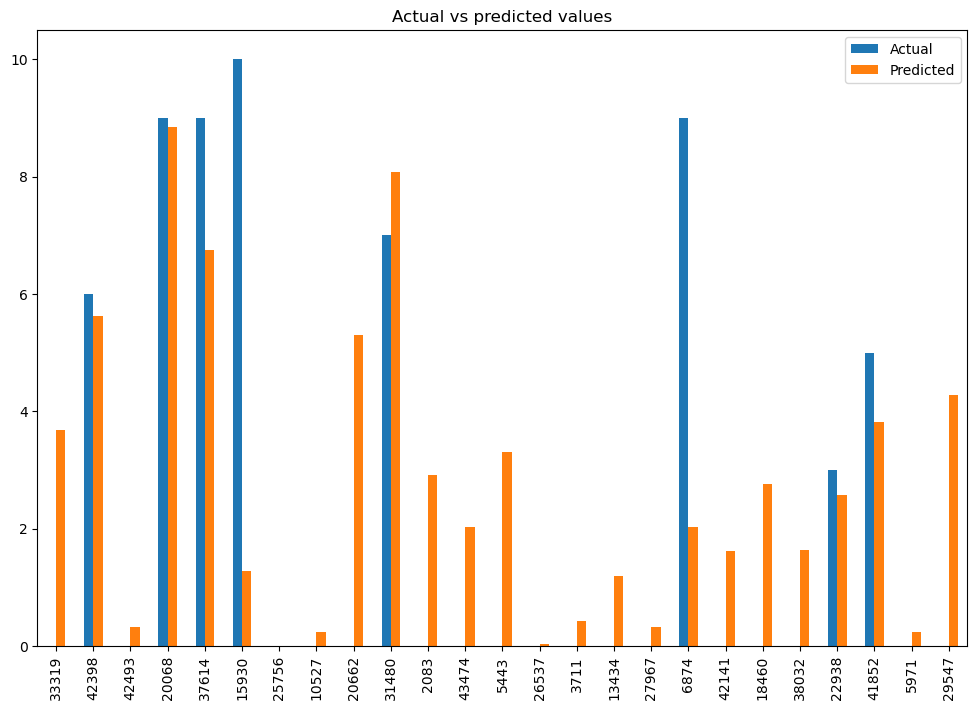

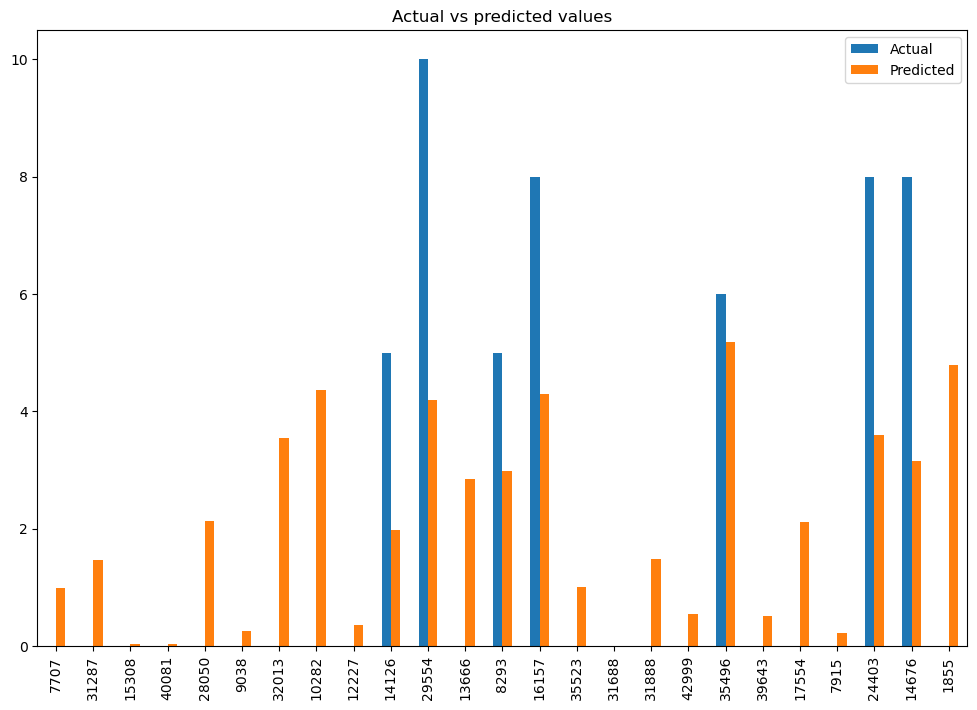

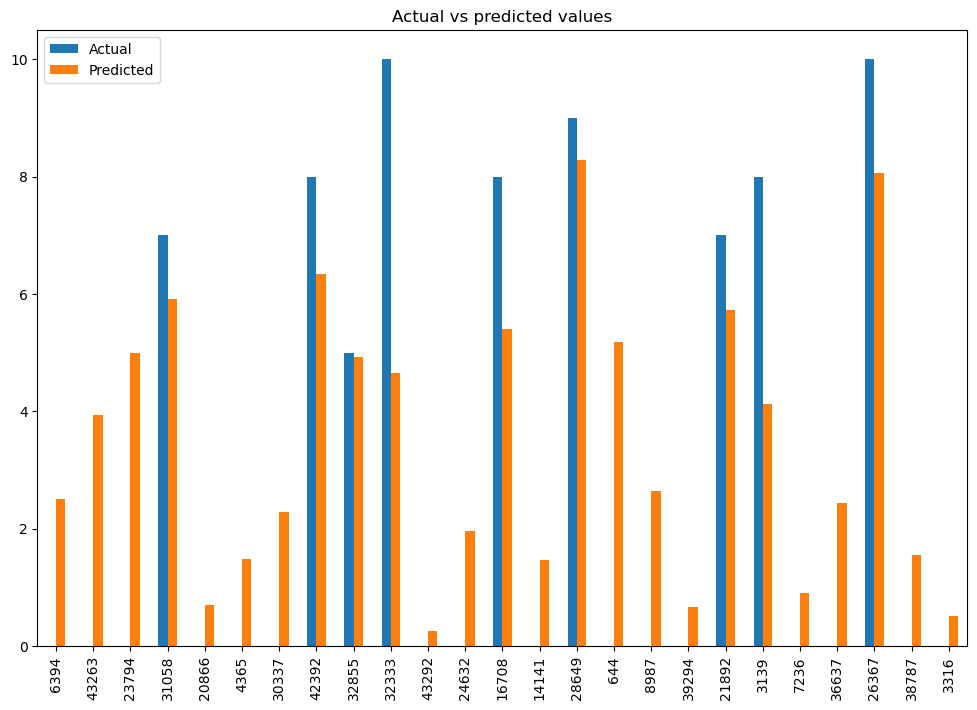

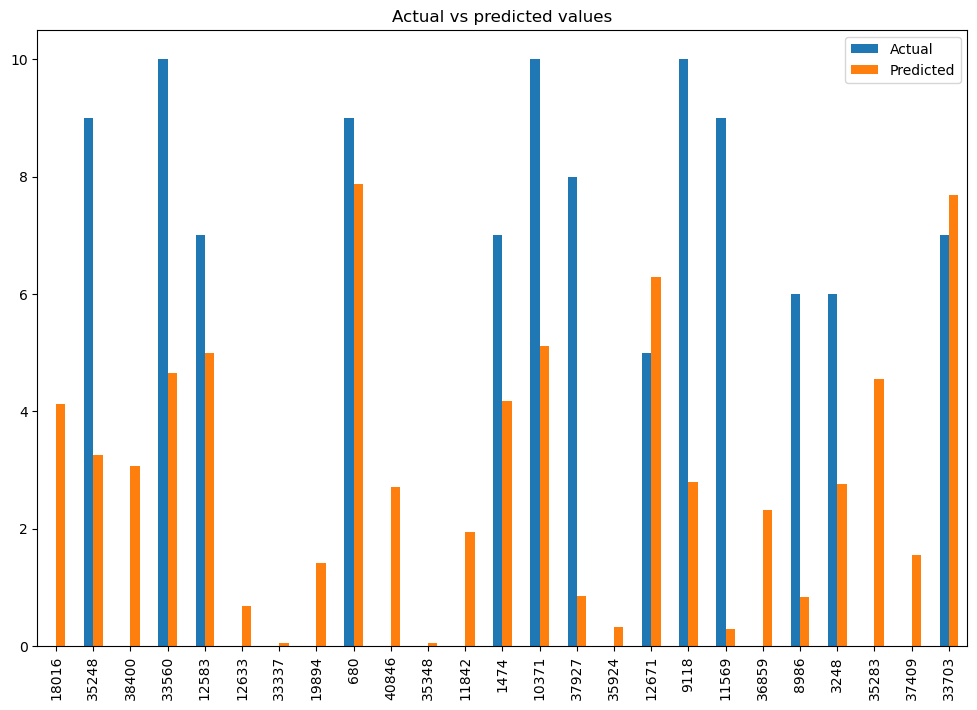

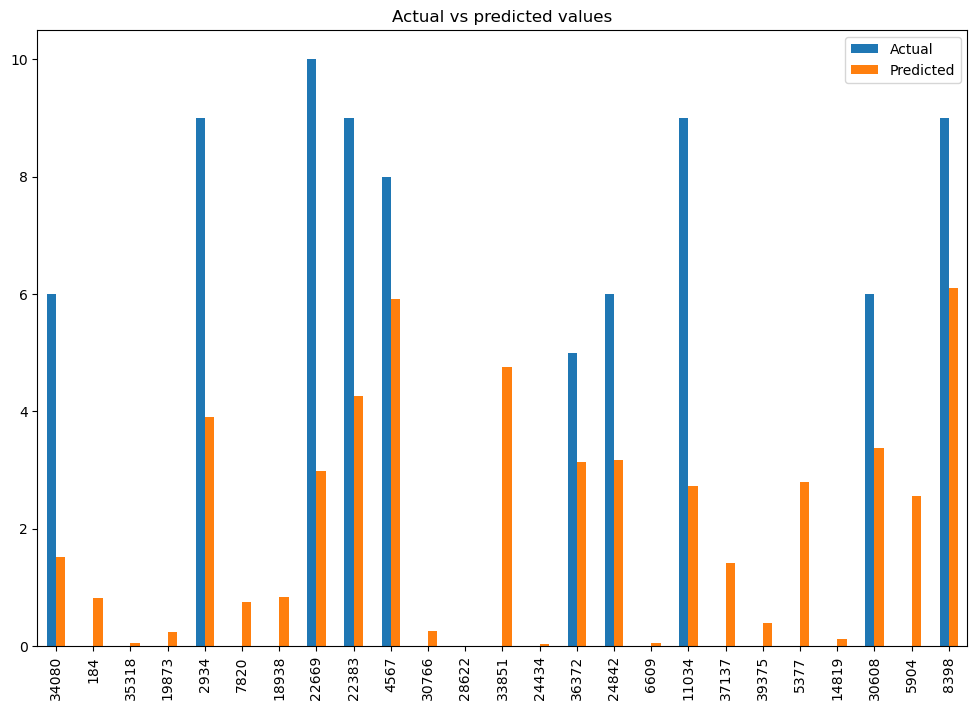

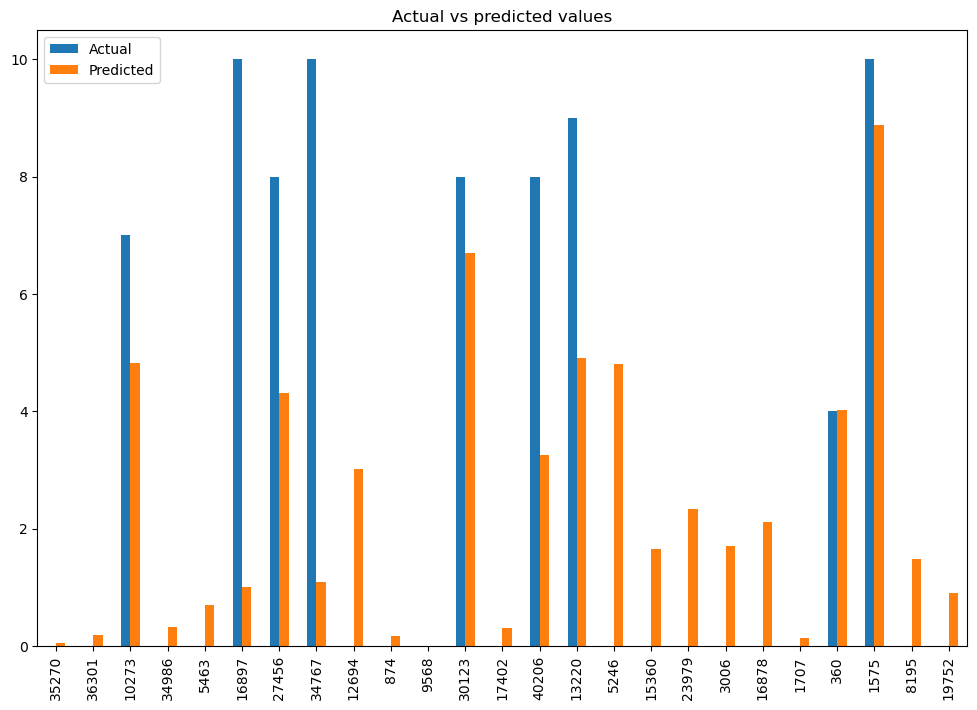

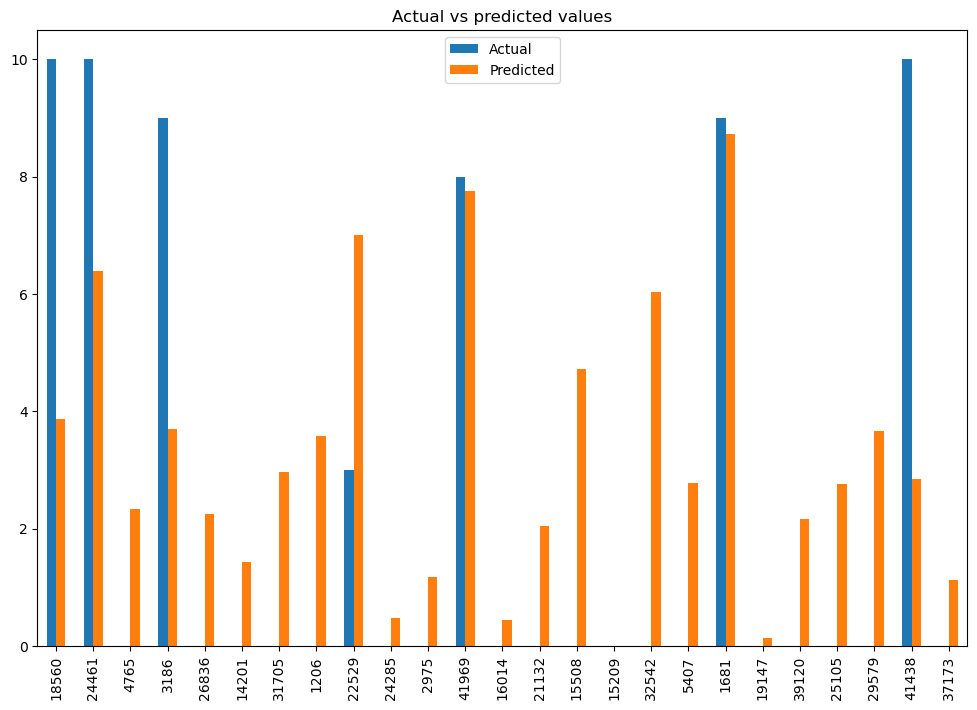

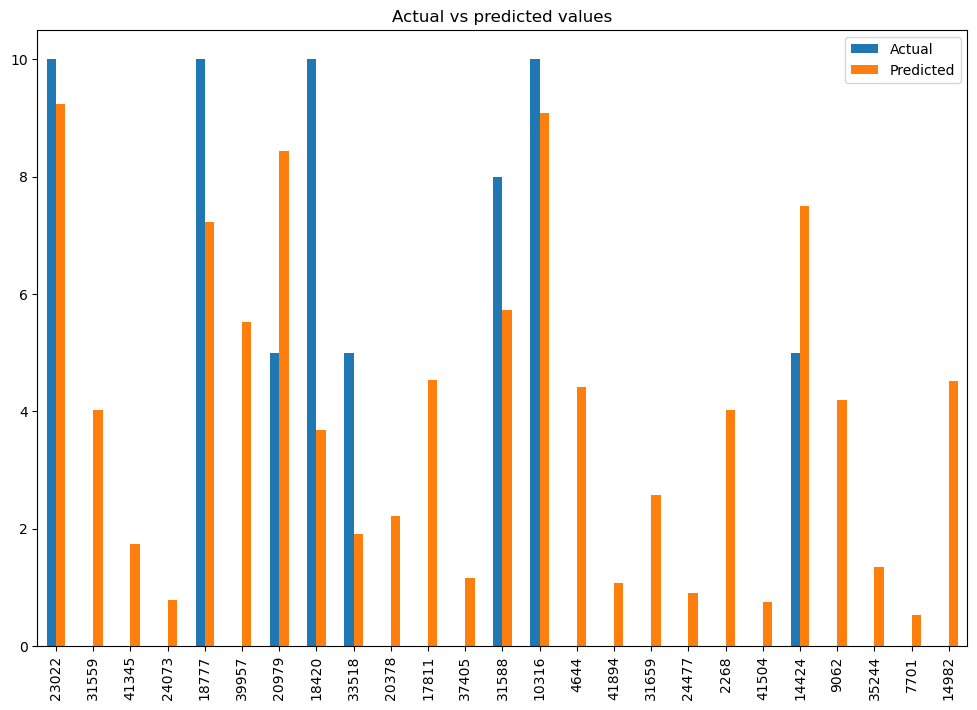

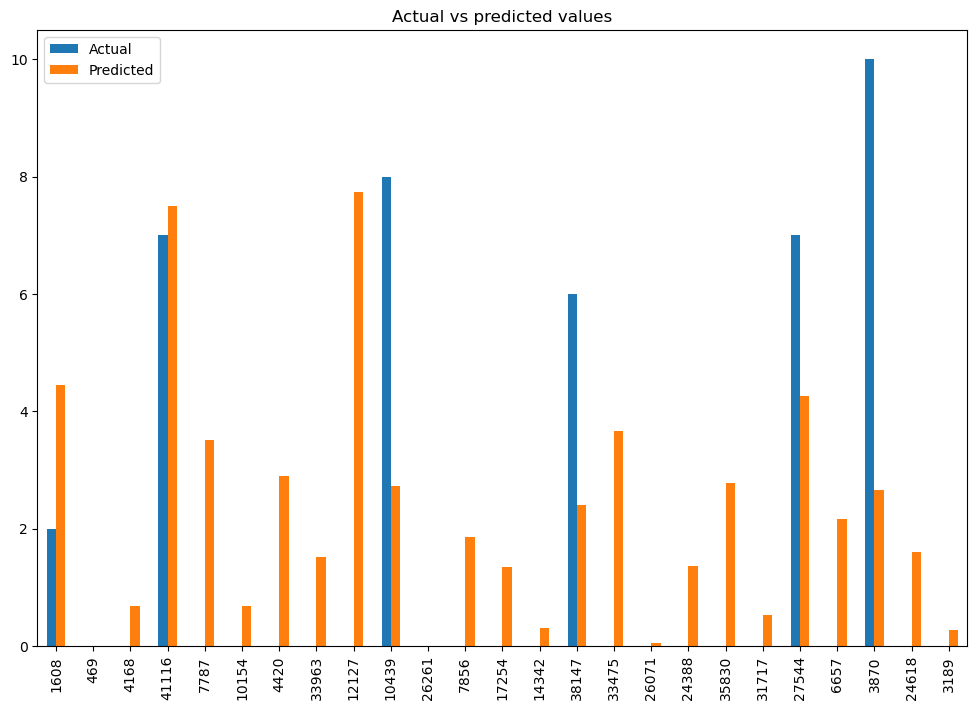

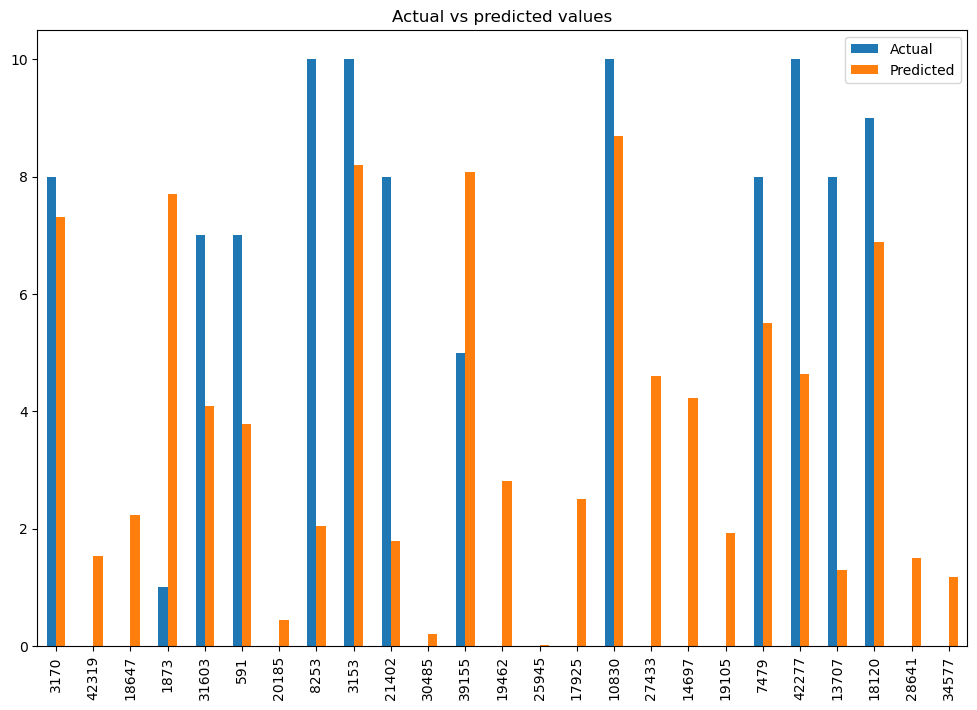

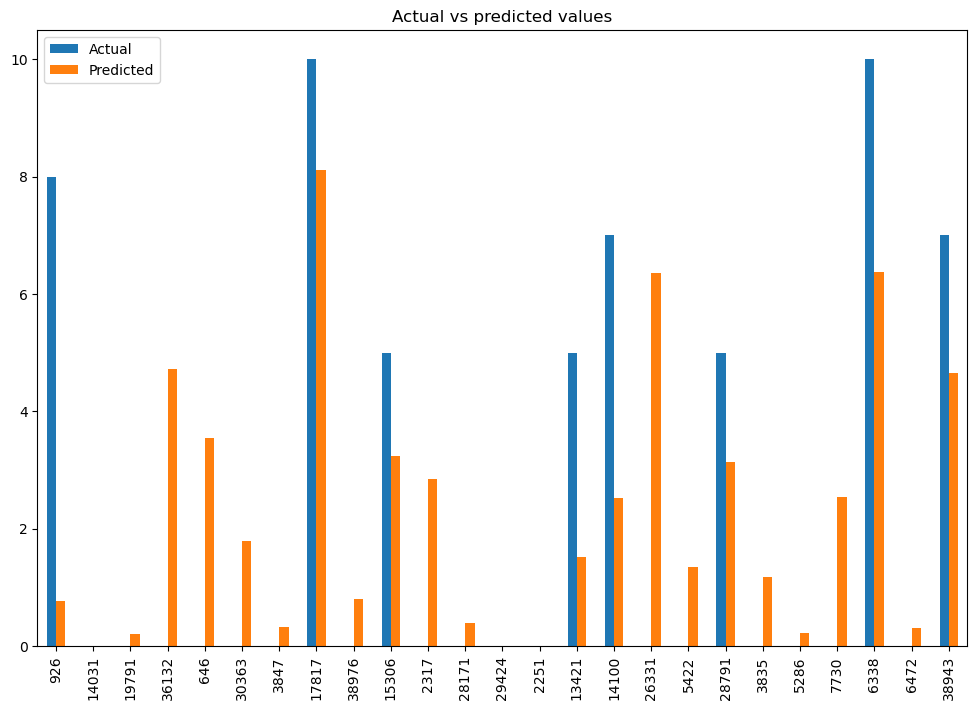

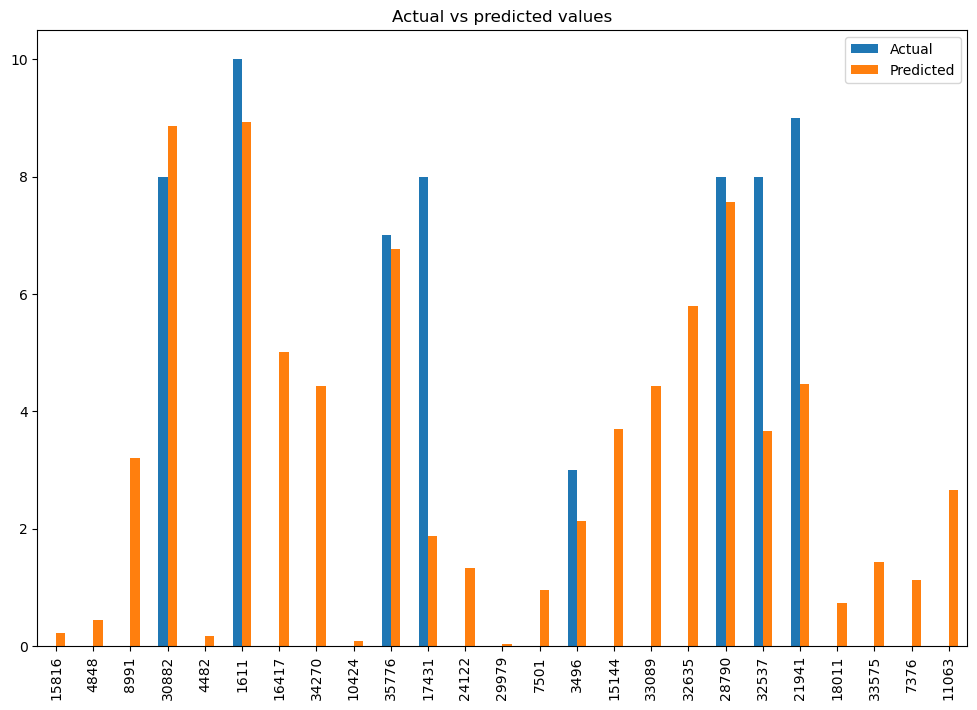

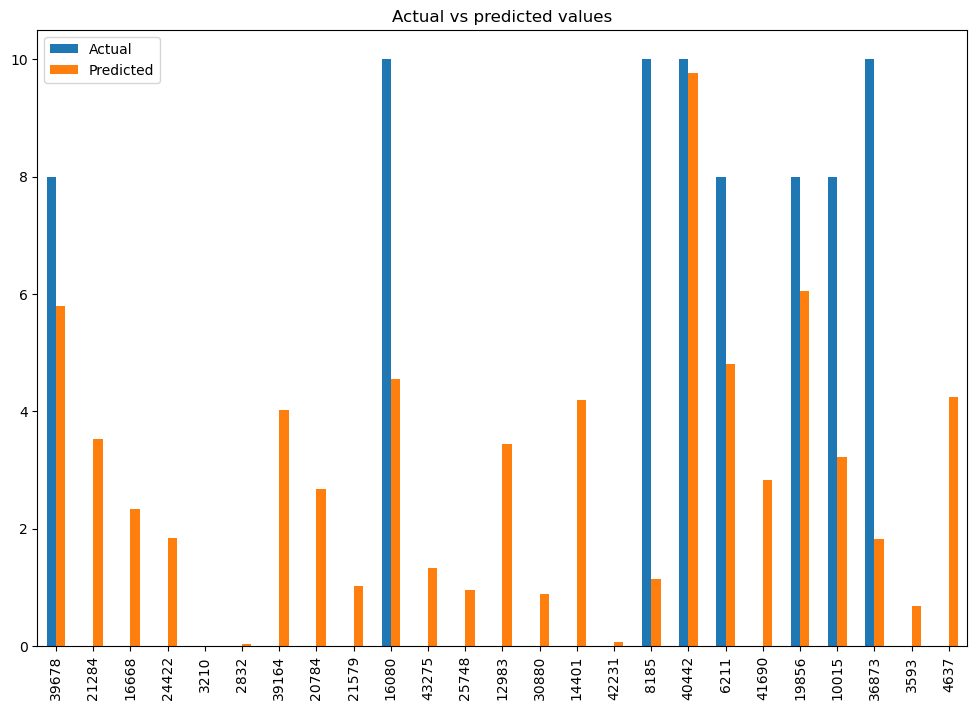

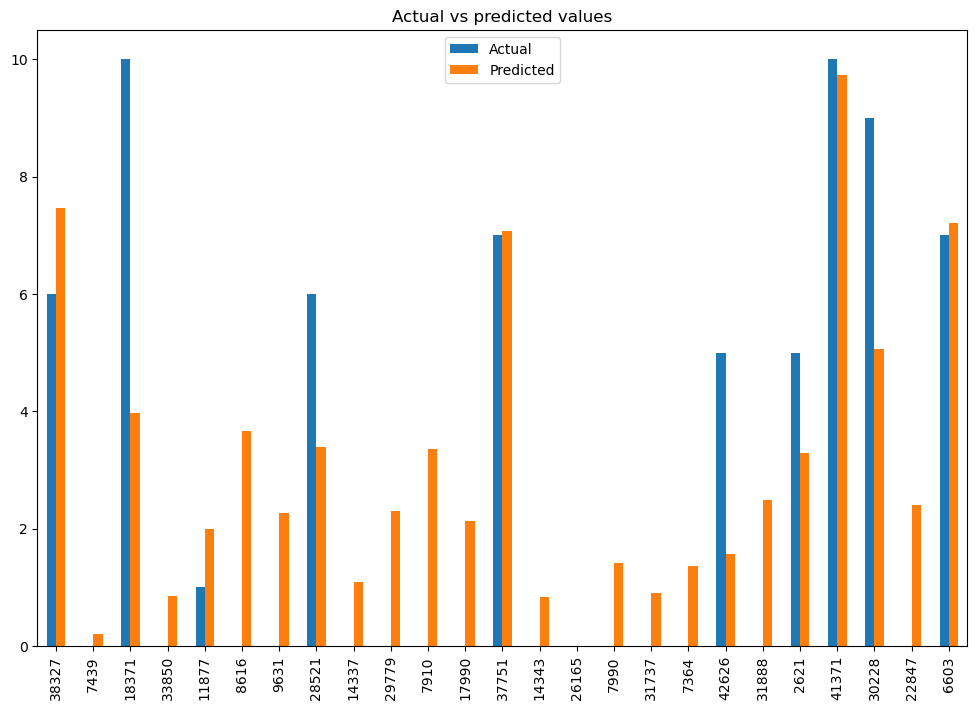

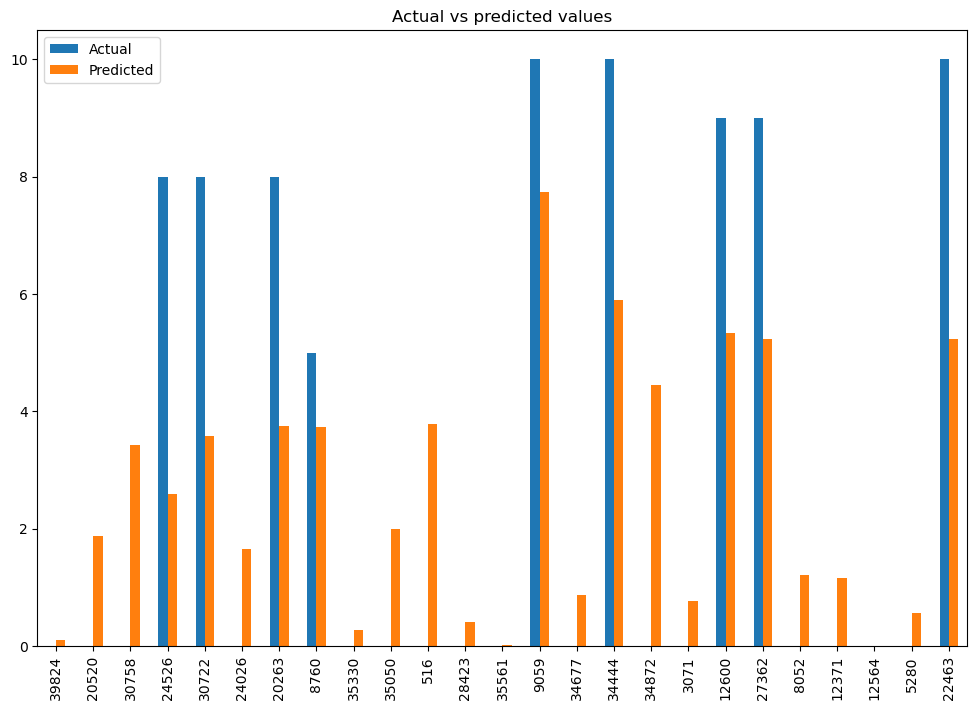

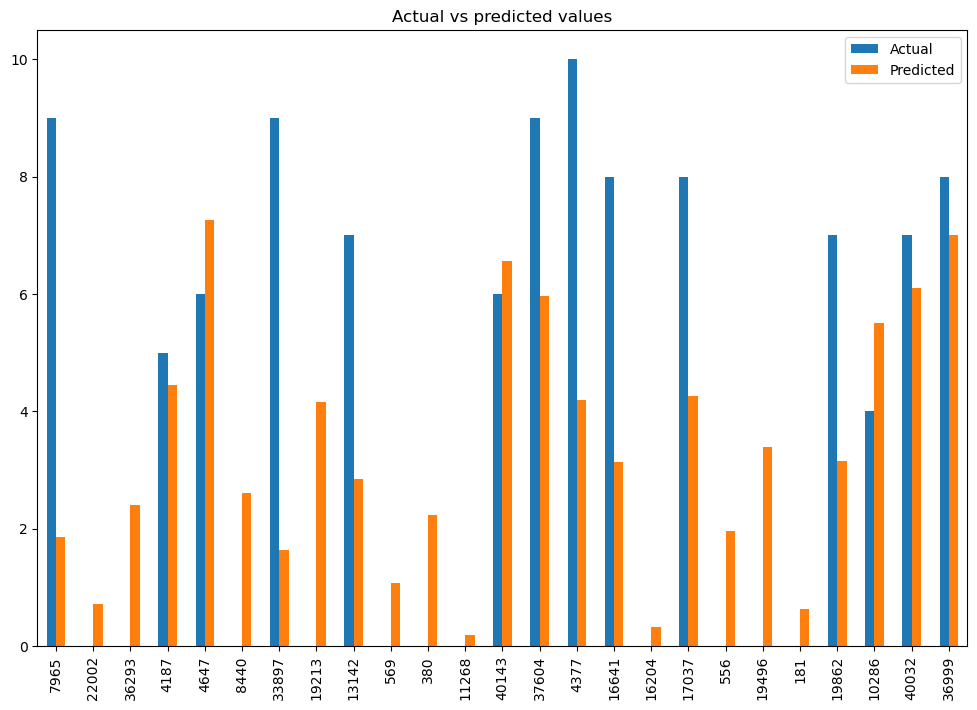

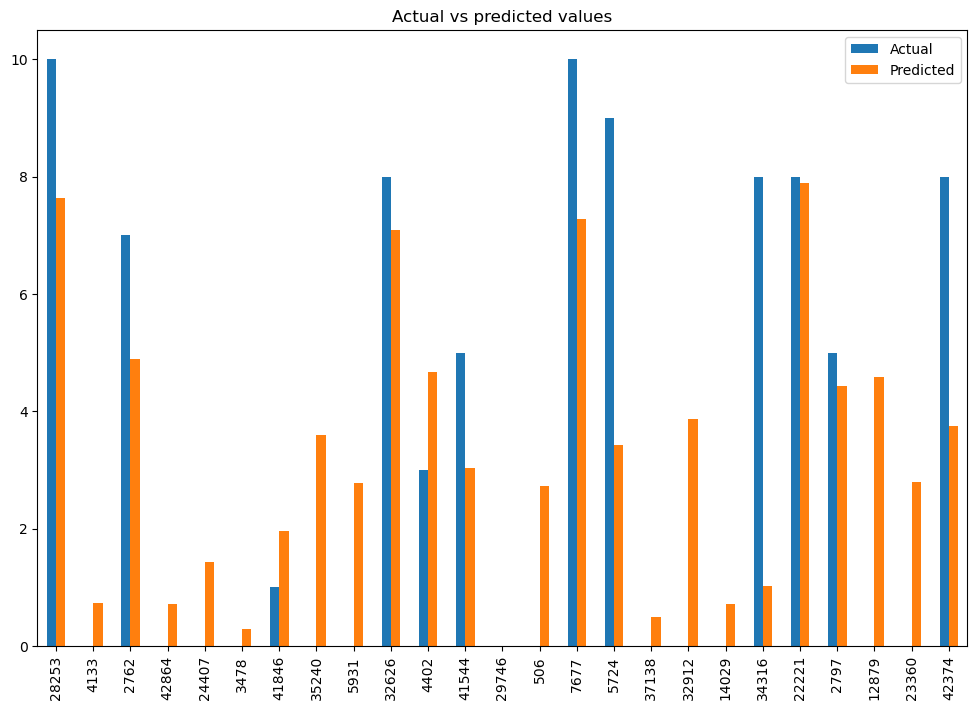

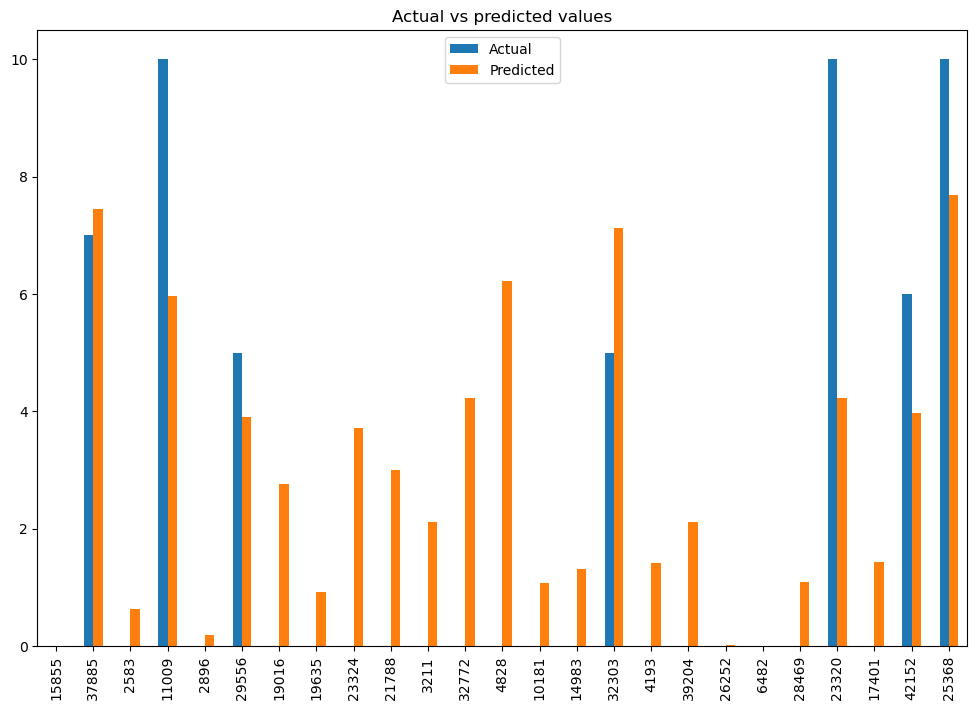

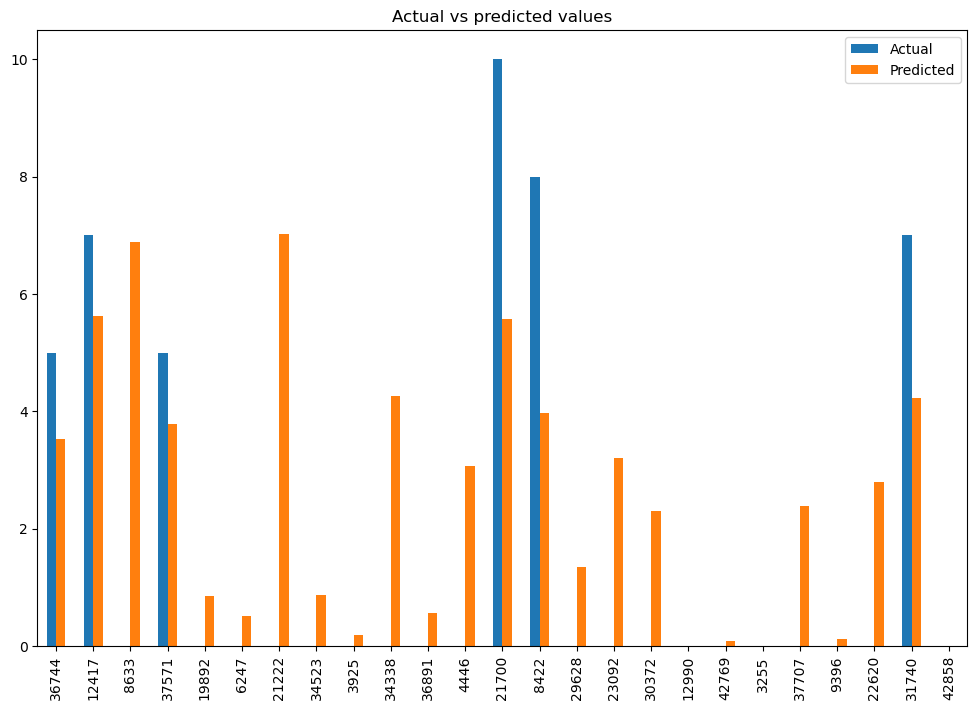

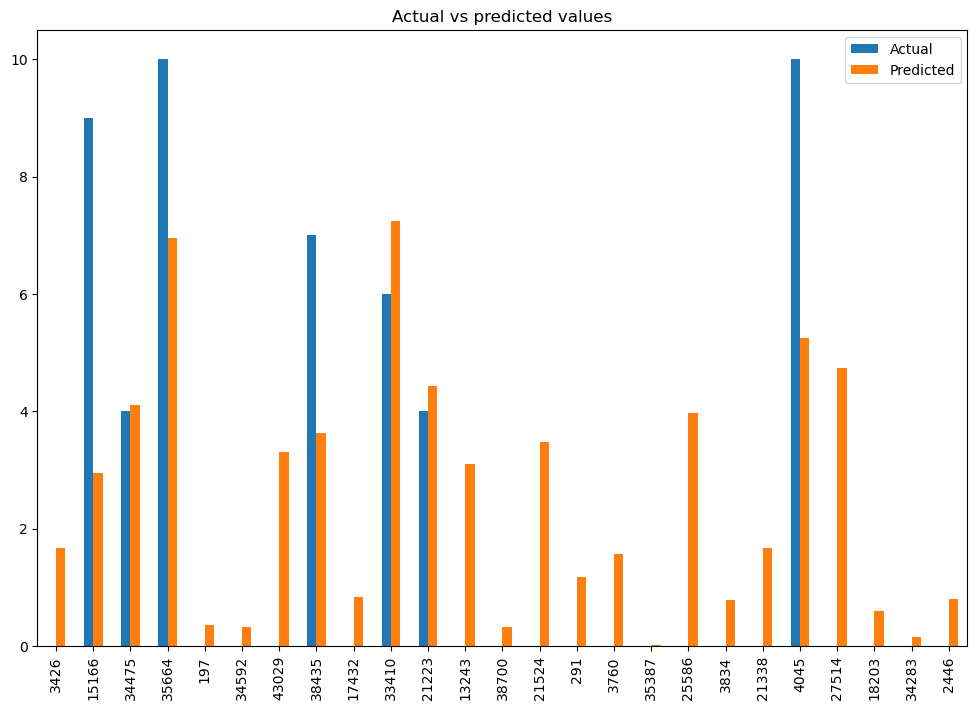

In [12]:
from sklearn.model_selection import KFold, StratifiedKFold
k = 20 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Rating_gb']# 'Pub_gb']

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


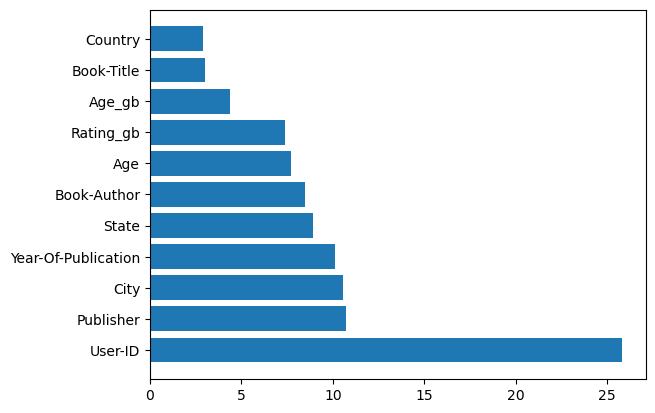

In [13]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()

In [14]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.372581
1,TEST_000001,6.299859
2,TEST_000002,5.928266
3,TEST_000003,5.759519
4,TEST_000004,5.557430
...,...,...
159616,TEST_159616,3.699777
159617,TEST_159617,3.408578
159618,TEST_159618,3.939240
159619,TEST_159619,3.892248


<Axes: xlabel='Book-Rating', ylabel='Count'>

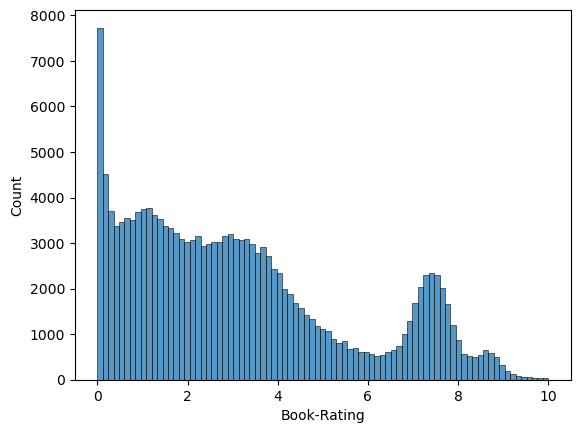

In [15]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [16]:
sub.to_csv('submit_cat+20-folds+test1.csv', index=False,encoding="utf-8-sig")